# Advanced ANNs: Increasing Data Volume

In [35]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
import copy
import metpy
import metpy.calc

In [34]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [4]:
# we will set the seed this time to ensure fairness
tf.random.set_seed(1)

In [15]:
al_asos = pd.read_csv("../Week_6/al_asos_jul_23_v2.csv")
#us_asos = pd.read_csv("/share/share/combined_asos_2023.csv")
us_asos = pd.read_csv("/home/sfreeman/teaching/sp24/combined_asos_2023.csv")

In [16]:
def nws_heat_index(T, RH):
    '''
    T in fahrenheit, RH in %
    https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml
    '''
    initial_hi =  0.5 * (T + 61.0 + ((T-68.0)*1.2) + (RH*0.094))
    if initial_hi < 80:
        return initial_hi

    adjustment_factor = 0
    if T>=80 and T<=112 and RH <13:
        adjustment_factor =  ((13-RH)/4)*np.sqrt((17-np.abs(T-95.))/17)
    
    if T>=80 and T<=87 and RH > 85:
         adjustment_factor = ((RH-85)/10) * ((87-T)/5)

    return (-42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - 
           .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH) + adjustment_factor

nws_heat_index_vectorized = np.vectorize(nws_heat_index)

In [17]:
al_asos

,station,valid,tmpf,tmpc,dwpf,dwpc,relh,feel,sknt,mslp,p01m,p01i,gust,skyc1,skyl1
0,HEY,2023-07-01 00:11,87.8,31.00,71.6,22.00,58.78,94.18,0.0,1013.0,0.0000,0.0000,NaN,CLR,NaN
1,SXS,2023-07-01 00:12,87.8,31.00,71.6,22.00,58.78,94.18,0.0,1013.6,0.0000,0.0000,NaN,CLR,NaN
2,HUA,2023-07-01 00:14,89.6,32.00,77.0,25.00,66.55,102.54,5.0,1013.9,0.0000,0.0000,NaN,FEW,4700.0
3,8A0,2023-07-01 00:15,86.0,30.00,73.4,23.00,66.15,93.45,0.0,NaN,0.0000,0.0000,NaN,CLR,NaN
4,4A6,2023-07-01 00:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64232,EKY,2023-07-30 23:56,79.0,26.11,76.0,24.44,90.55,79.00,0.0,1001.8,0.0000,0.0000,NaN,CLR,NaN
64233,79J,2023-07-30 23:56,76.0,24.44,73.0,22.78,90.44,76.00,4.0,1015.6,0.0000,0.0000,NaN,CLR,NaN
64234,SXS,2023-07-30 23:56,73.4,23.00,73.4,23.00,100.00,73.40,0.0,1015.1,0.0000,0.0000,NaN,FEW,500.0
64235,EUF,2023-07-30 23:58,79.0,26.11,75.0,23.89,87.58,79.00,0.0,1014.3,0.0000,0.0000,NaN,CLR,NaN


In [18]:
us_asos

,station,station_name,lat,lon,valid(UTC),tmpf,dwpf,sknt
0,AAF,APALACHICOLA MUNI (ASOS),29.7276,-85.0274,2023-01-01 05:00,61.0,62.0,1.0
1,AAF,APALACHICOLA MUNI (ASOS),29.7276,-85.0274,2023-01-01 06:00,60.0,61.0,1.0
2,AAF,APALACHICOLA MUNI (ASOS),29.7276,-85.0274,2023-01-01 07:00,59.0,60.0,3.0
3,AAF,APALACHICOLA MUNI (ASOS),29.7276,-85.0274,2023-01-01 08:00,59.0,60.0,1.0
4,AAF,APALACHICOLA MUNI (ASOS),29.7276,-85.0274,2023-01-01 09:00,58.0,60.0,1.0
...,...,...,...,...,...,...,...,...
6782526,ZZV,ZANESVILLE,39.9445,-81.8921,2023-12-31 19:00,42.0,33.0,9.0
6782527,ZZV,ZANESVILLE,39.9445,-81.8921,2023-12-31 20:00,42.0,34.0,7.0
6782528,ZZV,ZANESVILLE,39.9445,-81.8921,2023-12-31 21:00,42.0,34.0,6.0
6782529,ZZV,ZANESVILLE,39.9445,-81.8921,2023-12-31 22:00,41.0,34.0,4.0


In [19]:
al_asos['heat_index'] = nws_heat_index_vectorized(al_asos["tmpf"], al_asos['relh'])

/home/sfreeman/miniforge3/envs/aes690st_sp24/lib/python3.12/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in nws_heat_index (vectorized)
  outputs = ufunc(*inputs)


<Axes: >

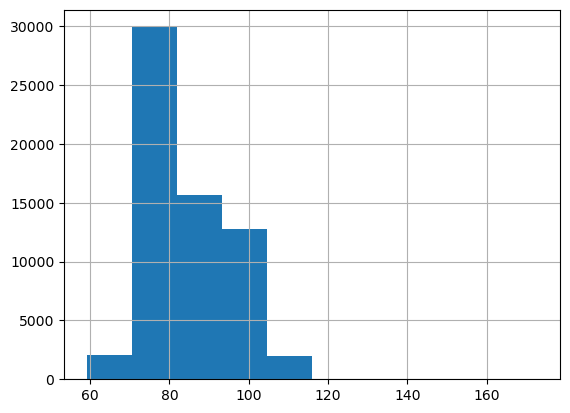

In [20]:
al_asos['heat_index'].hist()

In [21]:
us_asos['relh_raw'] = metpy.calc.relative_humidity_from_dewpoint(us_asos['tmpf'].values*metpy.units.units("degF"), 
                                                             us_asos['dwpf'].values*metpy.units.units("degF")).magnitude*100

In [22]:
us_asos['relh_raw'] 

0          103.602431
1          103.618159
2          103.633990
3          103.633990
4          107.416554
              ...    
6782526     70.192226
6782527     73.059775
6782528     73.059775
6782529     75.936726
6782530     82.150664
Name: relh_raw, Length: 6782531, dtype: float64

In [23]:
us_asos['relh'] = us_asos['relh_raw'].clip(0,100)

In [24]:
us_asos['heat_index'] = nws_heat_index_vectorized(us_asos["tmpf"], us_asos['relh'])

/home/sfreeman/miniforge3/envs/aes690st_sp24/lib/python3.12/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in nws_heat_index (vectorized)
  outputs = ufunc(*inputs)


<Axes: >

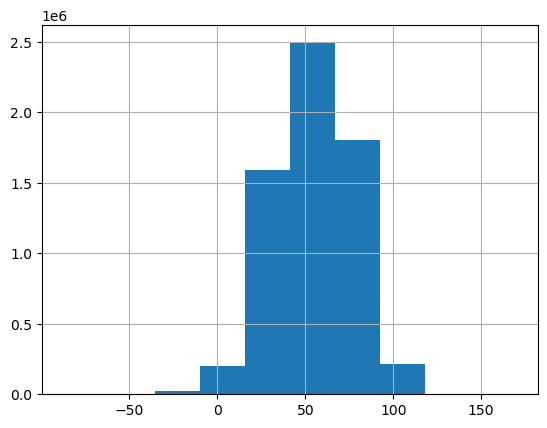

In [25]:
us_asos['heat_index'].hist()

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
us_asos_nona = us_asos.dropna(subset=['tmpf', 'relh', 'heat_index'])

In [30]:
# Prepare our data first

training_data_US, test_validation_US = train_test_split(us_asos_nona, test_size=0.25)
testing_data_US, validation_data_US = train_test_split(test_validation_US, test_size=0.5)

In [38]:
tf.keras.backend.clear_session()

input1 = keras.layers.Input(shape=(2, ))
input_norm = keras.layers.Normalization(axis=1)(input1)


dense1 = keras.layers.Dense(2048, input_dim=1, activation=None)(input_norm)
lerelu_layer = keras.layers.LeakyReLU(alpha=0.3)(dense1) 
dense2 = keras.layers.Dense(128, input_dim=1, activation=keras.activations.relu)(lerelu_layer)

output = keras.layers.Dense(1, activation=None, use_bias=True)(dense2)
model_US = keras.models.Model(inputs=[input1], outputs=[output])
model_US.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')
model_US.summary()

/home/sfreeman/miniforge3/envs/aes690st_sp24/lib/python3.12/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/sfreeman/miniforge3/envs/aes690st_sp24/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 2)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,550 (1.02 MB)

 Trainable params: 268,545 (1.02 MB)

 Non-trainable params: 5 (24.00 B)

<Axes: >

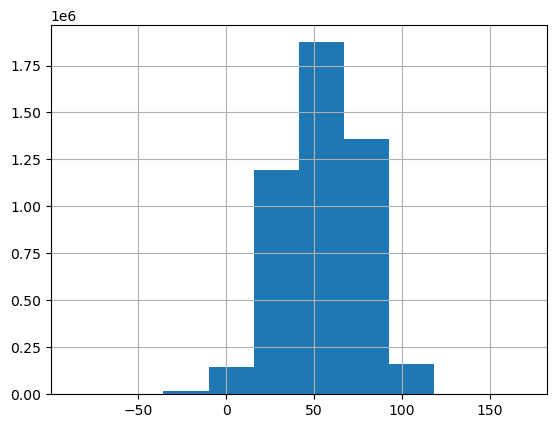

In [39]:
training_data_US['heat_index'].hist()

In [40]:
model_US.fit(training_data_US[['tmpf', 'relh']].values, 
           training_data_US['heat_index'].values, epochs=3, batch_size=1024, shuffle=True )

Epoch 1/3
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: 20.2162
Epoch 2/3
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - loss: 1.0748
Epoch 3/3
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - loss: 0.4301


24746/24746 ━━━━━━━━━━━━━━━━━━━━ 17s 683us/step


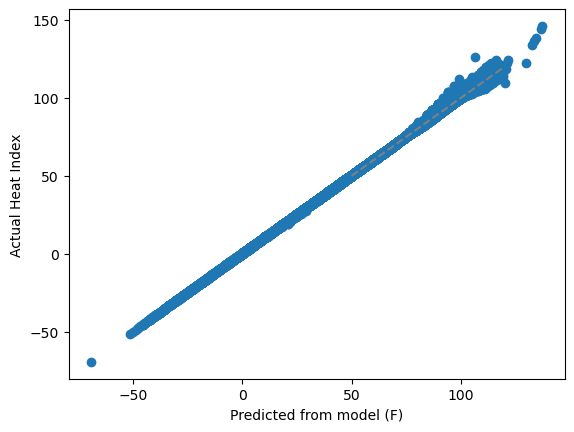

In [41]:
predicted_hi = model_US.predict(testing_data_US[['tmpf', 'relh']].values)
plt.scatter(predicted_hi, testing_data_US['heat_index'])
plt.xlabel("Predicted from model (F)")
plt.ylabel("Actual Heat Index")
#plt.xlim(50, 120)
#plt.ylim(50, 120)
plt.plot([50, 120], [50, 120], color='grey', ls='--')

In [42]:
model_US.save("my_usa_model.keras")